In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

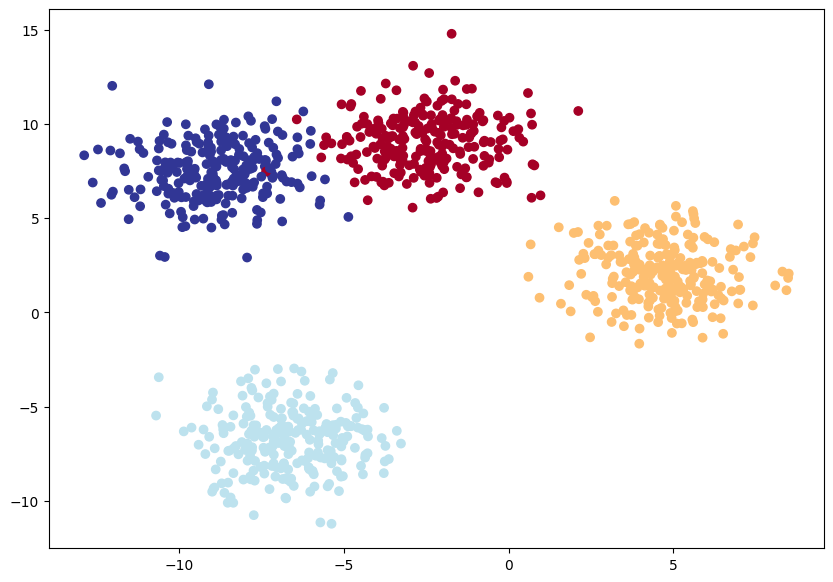

In [2]:
### Data Preparation

# 1. Create multi-class data
X_blob, y_blob = make_blobs(
    n_samples = 1000,
    n_features = NUM_FEATURES,
    centers = NUM_CLASSES,
    cluster_std = 1.5,
    random_state = RANDOM_SEED
)

# 2. Turn data into tensor
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,
    y_blob,
    test_size = 0.2,
    random_state = RANDOM_SEED
)

# 4. Plot
plt.figure(figsize = (10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c = y_blob, cmap = plt.cm.RdYlBu)

In [3]:
### Building model
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current device: {device}")

Current device: cuda


In [17]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = input_features, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

model_1 = BlobModel(input_features = NUM_FEATURES, output_features = NUM_CLASSES, hidden_units = 256).to(device)

model_1

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=4, bias=True)
  )
)

In [10]:
### Evaluation Metric
def accuracy_function(y_true, y_pred):
    # Calculate where those two are equal
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [18]:
### Training and Testing

torch.manual_seed(RANDOM_SEED)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr = 0.1)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training

    model_1.train()

    # 1. Forward-pass
    y_logits = model_1(X_blob_train.to(device))
    y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)

    # 2. Calculate loss/accuracy
    loss = loss_function(y_logits, y_blob_train)
    acc = accuracy_function(y_blob_train, y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Calculate gradients for back prop
    loss.backward()

    # 5. Updates parameters
    optimizer.step()

    ### Testing

    model_1.eval()

    with torch.inference_mode():
        # 1. Forward-pass
        test_logits = model_1(X_blob_test.to(device))
        test_pred = torch.softmax(test_logits, dim = 1).argmax(dim = 1)

        # 2. Calculate loss/accuracy
        test_loss = loss_function(test_logits, y_blob_test)
        test_acc = accuracy_function(y_blob_test, test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.46262, Acc: 1.25% | Test Loss: 1.05511, Test Acc: 68.50%
Epoch: 10 | Loss: 0.54128, Acc: 80.62% | Test Loss: 0.21618, Test Acc: 94.50%
Epoch: 20 | Loss: 0.03923, Acc: 99.12% | Test Loss: 0.03131, Test Acc: 99.00%
Epoch: 30 | Loss: 0.03317, Acc: 99.12% | Test Loss: 0.02495, Test Acc: 99.50%
Epoch: 40 | Loss: 0.03064, Acc: 99.12% | Test Loss: 0.02206, Test Acc: 99.50%
Epoch: 50 | Loss: 0.02917, Acc: 99.12% | Test Loss: 0.02032, Test Acc: 99.50%
Epoch: 60 | Loss: 0.02818, Acc: 99.12% | Test Loss: 0.01916, Test Acc: 99.50%
Epoch: 70 | Loss: 0.02744, Acc: 99.25% | Test Loss: 0.01831, Test Acc: 99.50%
Epoch: 80 | Loss: 0.02687, Acc: 99.25% | Test Loss: 0.01766, Test Acc: 99.50%
Epoch: 90 | Loss: 0.02641, Acc: 99.25% | Test Loss: 0.01713, Test Acc: 99.50%


In [12]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

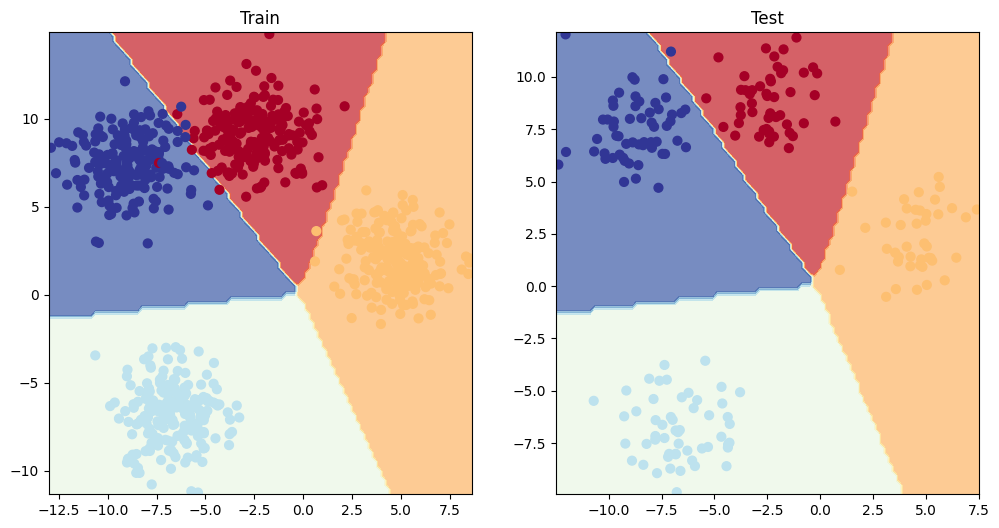

In [19]:
### Visualization
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_blob_test, y_blob_test)